In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json

# Load and prepare the dataset
file_path = 'goal_ticks.csv'

# Define column names based on the provided structure
column_names = [
    "kart_ID", "ball_X", "ball_Z", "ball_aim_X", "ball_aim_Z", "ball_node", "previous_X", "previous_Z", "ball_heading",
    "dist_to_ball", "kart_X", "kart_Z", "vel_X", "vel_Z", "speed", "kart_node", "target_encoded", "target_pos_X", "target_pos_Z", "goal"
]

df = pd.read_csv(file_path, header=None, names=column_names)

# # Drop 'ball_aim_X' and 'ball_aim_Z' columns
# df.drop(columns=["ball_aim_X", "ball_aim_Z"], inplace=True)

# Extract features and labels
X = df.iloc[:, :-1].values  # All columns except the last one (goal)
y = df['goal'].values  # The 'goal' column as binary

# Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler parameters for later use
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

print("Scaler parameters:")
print(json.dumps(scaler_params, indent=4))

with open('scaler_parameters.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Convert to long for CrossEntropyLoss

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the neural network architecture
class ScoringModel(nn.Module):
    def __init__(self, num_inputs=19):  # Set to 19 inputs based on the provided features
        super(ScoringModel, self).__init__()
        self.layer1 = nn.Linear(num_inputs, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 4)  # Assume 4 possible target classes
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Initialize the model with 19 inputs
model = ScoringModel(num_inputs=19)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training function
def train_model(train_loader, model, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Validation function
def validate_model(val_loader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f'Validation Loss: {total_loss / len(val_loader):.4f}')

# Train and validate the model
train_model(train_loader, model, criterion, optimizer, 2)
validate_model(val_loader, model, criterion)

# Save the trained model for deployment
model.eval()

example_input = torch.rand(1, X_train.shape[1])  # Generate a random example input
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("soccer_ai_model.pt")

# Print the weights of the output layer after training
print("Weights of the output layer after training:")
print(model.output_layer.weight)
print("Bias of the output layer after training:")
print(model.output_layer.bias)

# Example output
example_output = model(example_input)
print("Example output:", example_output)


Scaler parameters:
{
    "mean": [
        0.5,
        7.03485291887093,
        14.250105296244698,
        7.14708664982309,
        15.724125670811535,
        249.10122099341558,
        5.3638352357494865,
        5.7310856888458215,
        -0.1797107907969468,
        17.171180510324106,
        5.367925917716954,
        5.928873759444602,
        0.11076495693699233,
        2.1206476405808123,
        5.2864987534360415,
        292.17786869526304,
        0.025506616377932622,
        5.7025941531445765,
        7.597409486897588
    ],
    "scale": [
        0.5,
        23.221213047346684,
        34.424428725577066,
        23.73889378582459,
        34.594160120835205,
        138.44017378914054,
        22.12977898348211,
        36.24804644221655,
        1.6669115528507807,
        16.896626552677734,
        22.124191479752565,
        36.25128235258373,
        5.137189073010642,
        5.922027826576137,
        5.592623168290062,
        155.00814600369822,
    

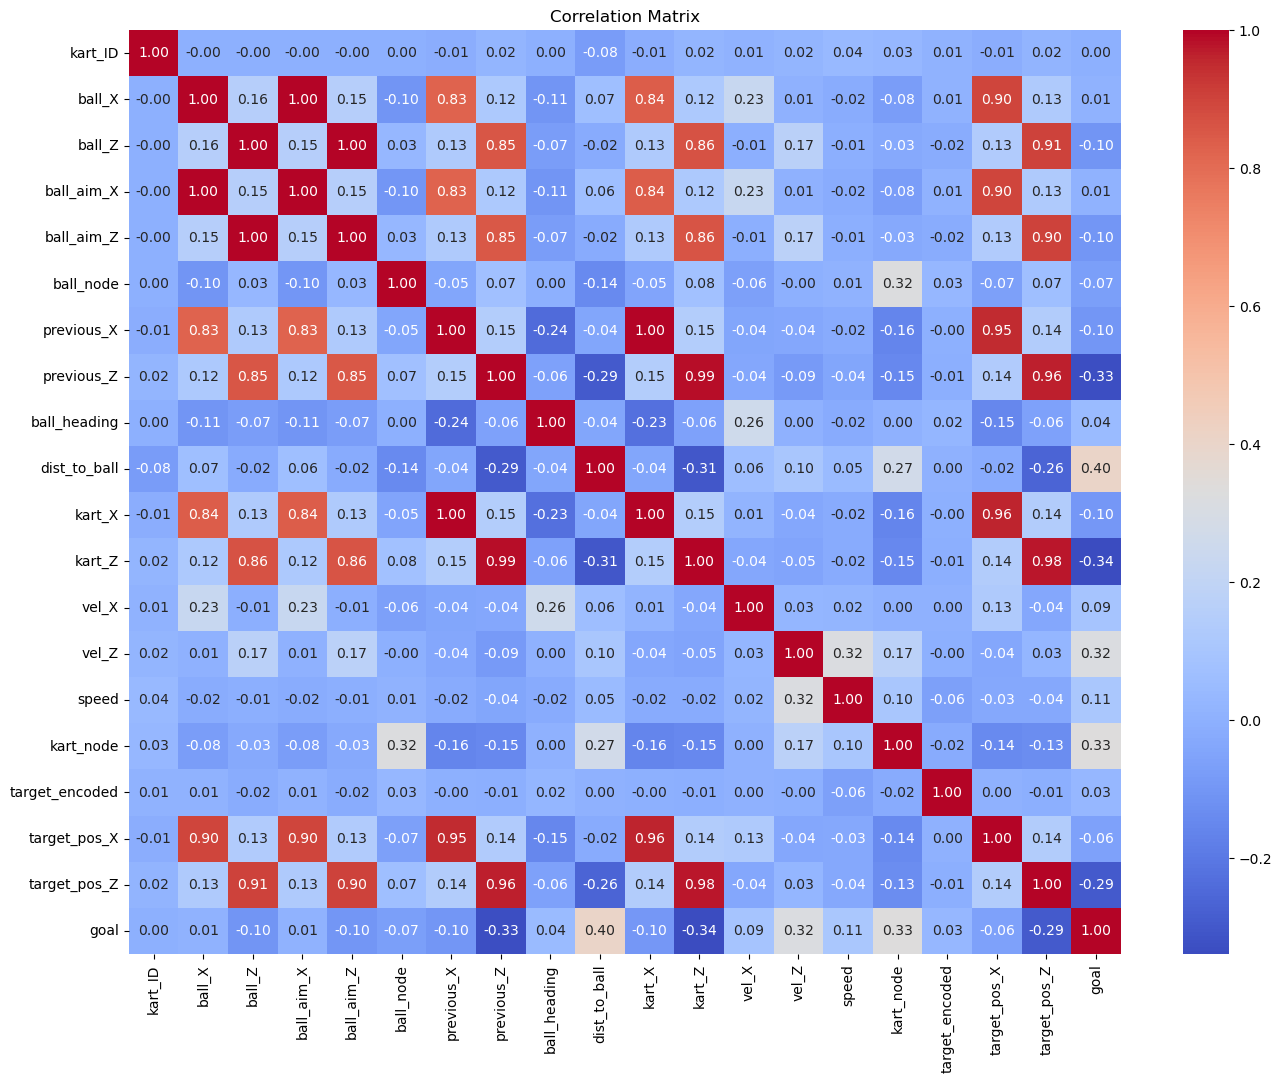

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()